In [2]:
# Using Python 3.12.1 (local env: HeatNSalt)

# Process the OTU table, starting with BOLD results. 

import pandas as pd
import numpy as np
import tiers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
BOLD_df = pd.read_excel('raw/BOLDResults_ExStreamEPT_apscale_OTUs_filtered_part_1.xlsx', engine='openpyxl')

In [3]:
# Separate metadata / taxa info from read_counts
otu_info = BOLD_df.iloc[:,:13]
read_matrix = BOLD_df.set_index('ID').iloc[:,13:] # one column less when ID is made index (Due to a typo, this [:,13:] here results in 743 specimen later instead of 744 (if it would be [:,12:]))

# Extract OTU number for sorting
otu_info = otu_info.assign(idno=otu_info['ID'].map(lambda x: x.split('_')[1]))
otu_info['idno'] = otu_info['idno'].astype(int)
otu_info = otu_info.sort_values('idno').reset_index(drop=True)
otu_info = otu_info.rename({'Species': 'species_short'}, axis=1)

# Add a column for two-part species name
species_not_na = ~otu_info['species_short'].isna()
otu_info['Species'] = np.nan
otu_info.loc[species_not_na, 'Species'] = otu_info[species_not_na].apply(lambda x: str(x['Genus']) + ' ' + str(x['species_short']), axis=1)
s_col = otu_info.pop('Species')
otu_info.insert(6, 'Species', s_col) # Put the column to the right place

# Create a taxon hierarchy table
# Separate taxon information and add Kingdom value
otu_taxa_table = otu_info.iloc[:,:7].set_index('ID')
otu_taxa_table.insert(loc=0, column='Kingdom', value='Animalia')


# set column names to lowercase
otu_taxa_table.columns = otu_taxa_table.columns.map(lambda x: x.lower())
otu_taxa_table = otu_taxa_table.assign(type=np.nan)
otu_taxa_table = tiers.fill_gaps(otu_taxa_table)
otu_taxa_table = otu_taxa_table.assign(label=tiers.get_leaves(otu_taxa_table))

# Merge to final otu_info table
otu_info = otu_taxa_table.merge(otu_info, left_index=True, right_on='ID')

# Drop the old hierarchy before merging
otu_info = otu_info.drop(['Phylum', 'Class', 'Order', 'Family', 'Genus', 'species'],axis=1)

# Duplicates are removed from otu_taxa_table
otu_taxa_table = otu_taxa_table.drop_duplicates(keep='first').sort_values(otu_taxa_table.columns.tolist()).reset_index(drop=True)


# Handle read matrix
otu_sums = read_matrix.sum(axis=1)
any(otu_sums != 0)
# if True, Each OTU has some reads

# Function to get ordered list of non-zero values with indices
def non_zero_values(df):
    result = {}
    for col in df.columns:
        non_zero_values = df[col][df[col] != 0]  # Filter non-zero values
        if non_zero_values.empty:
            result[col] = []
            continue
        ordered_values = non_zero_values.sort_values()  # Sort by value
        result[col] = list(zip(ordered_values.index.astype(str), ordered_values))  # Store indices and values as list of tuples
    return result

ordered_non_zero_values = non_zero_values(read_matrix)

def replace_string_in_tuple(tup, df):
    id_value, reads = tup
    row = df.loc[df['ID'] == id_value]

    # Check if the ID in the tuple matches with the ID in the DataFrame
    if not row.empty:
        # Find the corresponding label value from the DataFrame
        corresponding_label = row['label'].iloc[0]
        corresponding_species = row['Species'].iloc[0]
        corresponding_genus = row['genus'].iloc[0]
        corresponding_family = row['family'].iloc[0]
        corresponding_order = row['order'].iloc[0]
        # Replace the label value in the tuple
        return (id_value, corresponding_order, corresponding_family, corresponding_genus, corresponding_species, corresponding_label, reads)
    else:
        return tup  # If no matching ID is found, return the original tuple
    
species_dict = {}
count = 0
for sample, hits in ordered_non_zero_values.items():
    for hit in hits:
        species_dict[count] = [sample, replace_string_in_tuple(hit, otu_info)]
        count += 1

Megabarcoding_df = pd.DataFrame.from_dict(species_dict, orient='index')
Megabarcoding_df[['OTU', 'Order', 'Family', 'Genus', 'Species', 'Label', 'read count']] = pd.DataFrame(Megabarcoding_df[1].tolist(), index=Megabarcoding_df.index)
Megabarcoding_df = Megabarcoding_df.drop(columns=[1])
Megabarcoding_df = Megabarcoding_df.sort_values(by=[0, 'read count'], ascending=[True, False])

# During pre-processing a wrong plate tagging format was used. 
# The remap file is used to take care of renaming the old wrong IDs to the correct ones.
remap = pd.read_excel('raw/plate_remap_new.xlsx') 
renaming_dict = dict(zip(remap['Old_name'], remap['New_name']))
Megabarcoding_df[0] = Megabarcoding_df[0].replace(renaming_dict)
Megabarcoding_df = Megabarcoding_df.rename(columns={0: 'Sample'})
Megabarcoding_max_df = Megabarcoding_df.drop_duplicates(subset='Sample')

with pd.ExcelWriter('outputs/EPT_OTU_reads.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    Megabarcoding_max_df.to_excel(writer, sheet_name='Top Hits', index=False)
    Megabarcoding_df.to_excel(writer, sheet_name='All reads', index=False)

reads = read_matrix.reset_index().melt(id_vars='ID', var_name='sample_name', value_name='reads').set_index(['ID', 'sample_name'])

# Check that the pivot works
pivoted = reads.pivot_table(index='ID', columns='sample_name', values='reads', aggfunc='sum')[read_matrix.columns]
np.all(pivoted.values == read_matrix.values)

otu_info.to_csv('outputs/otu_info.csv', index=False)
otu_taxa_table.to_csv('outputs/otu_taxa_table.csv',index=False)
reads.loc[reads['reads'] !=0].to_csv('outputs/otu_reads.csv', index=False)

Megabarcoding_df = Megabarcoding_df.merge(remap[['New_name', 'Plate']], left_on='Sample', right_on= 'New_name', how='left').drop(columns=['New_name'])

/var/folders/b0/68bb2dkj42g1jr38kdd8m6pc0000gp/T/ipykernel_92689/4262365182.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Limnephilus lunatus' 'Goera pilosa' 'Potamophylax rotundipennis' ...
 'Corynoptera perpusilla' 'Polistes dominula' 'Chironomus cingulatus']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  otu_info.loc[species_not_na, 'Species'] = otu_info[species_not_na].apply(lambda x: str(x['Genus']) + ' ' + str(x['species_short']), axis=1)


In [4]:
NCs = pd.concat([remap[remap['New_name'].str.contains('NC')], remap[remap['New_name'].str.contains('D6')]])
NCs_list = NCs['New_name'].to_list()
Negative_controls_df = Megabarcoding_df[Megabarcoding_df['Sample'].isin(NCs_list)]
Megabarcoding_df_woNC = Megabarcoding_df[~Megabarcoding_df['Sample'].isin(NCs_list)]
Negative_controls_df_wo6 = Negative_controls_df[Negative_controls_df['Plate'] != 6]
Megabarcoding_df_woNC_wo6 = Megabarcoding_df_woNC[Megabarcoding_df_woNC['Plate'] != 6]
Megabarcoding_df_wo6 = Megabarcoding_df[Megabarcoding_df['Plate'] != 6]

In [5]:
EPT = ['Ephemeroptera', 'Plecoptera', 'Trichoptera']
def only_EPTs(df):
    df = df[df['Order'].isin(EPT)]
    return df

In [6]:
print(f'Number of negative controls: {len(NCs_list)}')
print(f'Number of negative controls with reads: {Negative_controls_df['Sample'].nunique()} ({Negative_controls_df['Sample'].nunique()/len(NCs_list)*100}%)')
print(f'Number of negative controls with hits above 1000 reads: {Negative_controls_df[Negative_controls_df['read count'] >1000]['Sample'].nunique()} ({Negative_controls_df[Negative_controls_df['read count'] >1000]['Sample'].nunique()/len(NCs_list)*100}%)')

print(f'Total reads in negative controls: {Negative_controls_df['read count'].sum()} (of {Megabarcoding_df['read count'].sum()} total reads ({(Negative_controls_df['read count'].sum()/Megabarcoding_df['read count'].sum()*100).round(2)}%))')
print(f'EPT reads in negative controls: {only_EPTs(Negative_controls_df)['read count'].sum()} (of {only_EPTs(Megabarcoding_df)['read count'].sum()} EPT reads ({(only_EPTs(Negative_controls_df)['read count'].sum()/only_EPTs(Megabarcoding_df)['read count'].sum()*100).round(2)}%))')
print(f'Number of OTUs in negative controls: {Negative_controls_df['OTU'].nunique()} (of {Megabarcoding_df['OTU'].nunique()} total OTUs ({((Negative_controls_df['OTU'].nunique()/Megabarcoding_df['OTU'].nunique())*100)}%))')
print(f'Number of EPT OTUs in negative controls: {only_EPTs(Negative_controls_df)['OTU'].nunique()} (of {only_EPTs(Megabarcoding_df)['OTU'].nunique()} EPT OTUs ({((only_EPTs(Negative_controls_df)['OTU'].nunique()/only_EPTs(Megabarcoding_df)['OTU'].nunique())*100)}%))')

print(f'Total reads in negative controls without plate 6: {Negative_controls_df_wo6['read count'].sum()} (of {Megabarcoding_df_wo6['read count'].sum()} total reads ({(Negative_controls_df_wo6['read count'].sum()/Megabarcoding_df_wo6['read count'].sum()*100).round(2)}%))')
print(f'{((1-(Negative_controls_df_wo6['read count'].sum()/Negative_controls_df['read count'].sum()))*100).round(2)}% of reads in negative controls are on plate 6')
print(f'EPT reads in negative controls without plate 6: {only_EPTs(Negative_controls_df_wo6)['read count'].sum()} (of {only_EPTs(Megabarcoding_df_wo6)['read count'].sum()} EPT reads ({(only_EPTs(Negative_controls_df_wo6)['read count'].sum()/only_EPTs(Megabarcoding_df_wo6)['read count'].sum()*100).round(2)}%))')
print(f'Number of OTUs in negative controls without plate 6: {Negative_controls_df_wo6['OTU'].nunique()} (of {Megabarcoding_df_wo6['OTU'].nunique()} total OTUs ({((Negative_controls_df_wo6['OTU'].nunique()/Megabarcoding_df_wo6['OTU'].nunique())*100)}%))')
print(f'Number of EPT OTUs in negative controls without plate 6: {only_EPTs(Negative_controls_df_wo6)['OTU'].nunique()} (of {only_EPTs(Megabarcoding_df_wo6)['OTU'].nunique()} EPT OTUs ({((only_EPTs(Negative_controls_df_wo6)['OTU'].nunique()/only_EPTs(Megabarcoding_df_wo6)['OTU'].nunique())*100)}%))')

print('Information about average number of reads per negative control with plate 6:')
pd.DataFrame(Negative_controls_df.groupby('Sample')['read count'].sum().describe().round(2))

Number of negative controls: 19
Number of negative controls with reads: 14 (73.68421052631578%)
Number of negative controls with hits above 1000 reads: 6 (31.57894736842105%)
Total reads in negative controls: 973228 (of 211969611 total reads (0.46%))
EPT reads in negative controls: 521489 (of 193694620 EPT reads (0.27%))
Number of OTUs in negative controls: 476 (of 5501 total OTUs (8.652972186875113%))
Number of EPT OTUs in negative controls: 33 (of 129 EPT OTUs (25.581395348837212%))
Total reads in negative controls without plate 6: 584976 (of 193141506 total reads (0.3%))
39.89% of reads in negative controls are on plate 6
EPT reads in negative controls without plate 6: 490352 (of 183902932 EPT reads (0.27%))
Number of OTUs in negative controls without plate 6: 16 (of 1531 total OTUs (1.0450685826257349%))
Number of EPT OTUs in negative controls without plate 6: 11 (of 50 EPT OTUs (22.0%))
Information about average number of reads per negative control with plate 6:


,read count
count,14.00
mean,69516.29
std,120846.35
min,1.00
25%,1.00
50%,230.50
75%,86439.25
max,388252.00


In [7]:
print('Information about average number of reads per negative control without plate 6:')
pd.DataFrame(Negative_controls_df_wo6.groupby('Sample')['read count'].sum().describe().round(2))

Information about average number of reads per negative control without plate 6:


,read count
count,13.00
mean,44998.15
std,81875.24
min,1.00
25%,1.00
50%,3.00
75%,77389.00
max,286731.00


In [8]:
info_df = Megabarcoding_df.groupby('Plate')['read count'].describe()
info_df['sum'] = Megabarcoding_df.groupby('Plate')['read count'].sum()

In [9]:
info_df

,count,mean,std,min,25%,50%,75%,max,sum
Plate,,,,,,,,,
1,1223.0,18067.891251,65633.790464,1.0,3.00,19.0,137.50,421681.0,22097031
2,1306.0,14529.737366,56546.833447,1.0,3.00,18.0,151.50,374214.0,18975837
3,1104.0,15356.535326,61859.120536,1.0,4.00,28.5,318.25,460254.0,16953615
4,1048.0,11153.191794,47132.388980,1.0,3.00,18.0,137.50,360392.0,11688545
5,1453.0,14230.488644,59751.685522,1.0,6.00,41.0,341.00,445894.0,20676900
6,30718.0,612.933948,7515.670888,1.0,26.00,96.0,284.00,345032.0,18828105
7,1681.0,9636.113623,48488.047216,1.0,7.00,46.0,311.00,422375.0,16198307
8,1283.0,11142.064692,51893.923219,1.0,3.00,15.0,146.50,554101.0,14295269
9,1158.0,14067.160622,58117.771467,1.0,5.00,38.0,451.75,411385.0,16289772


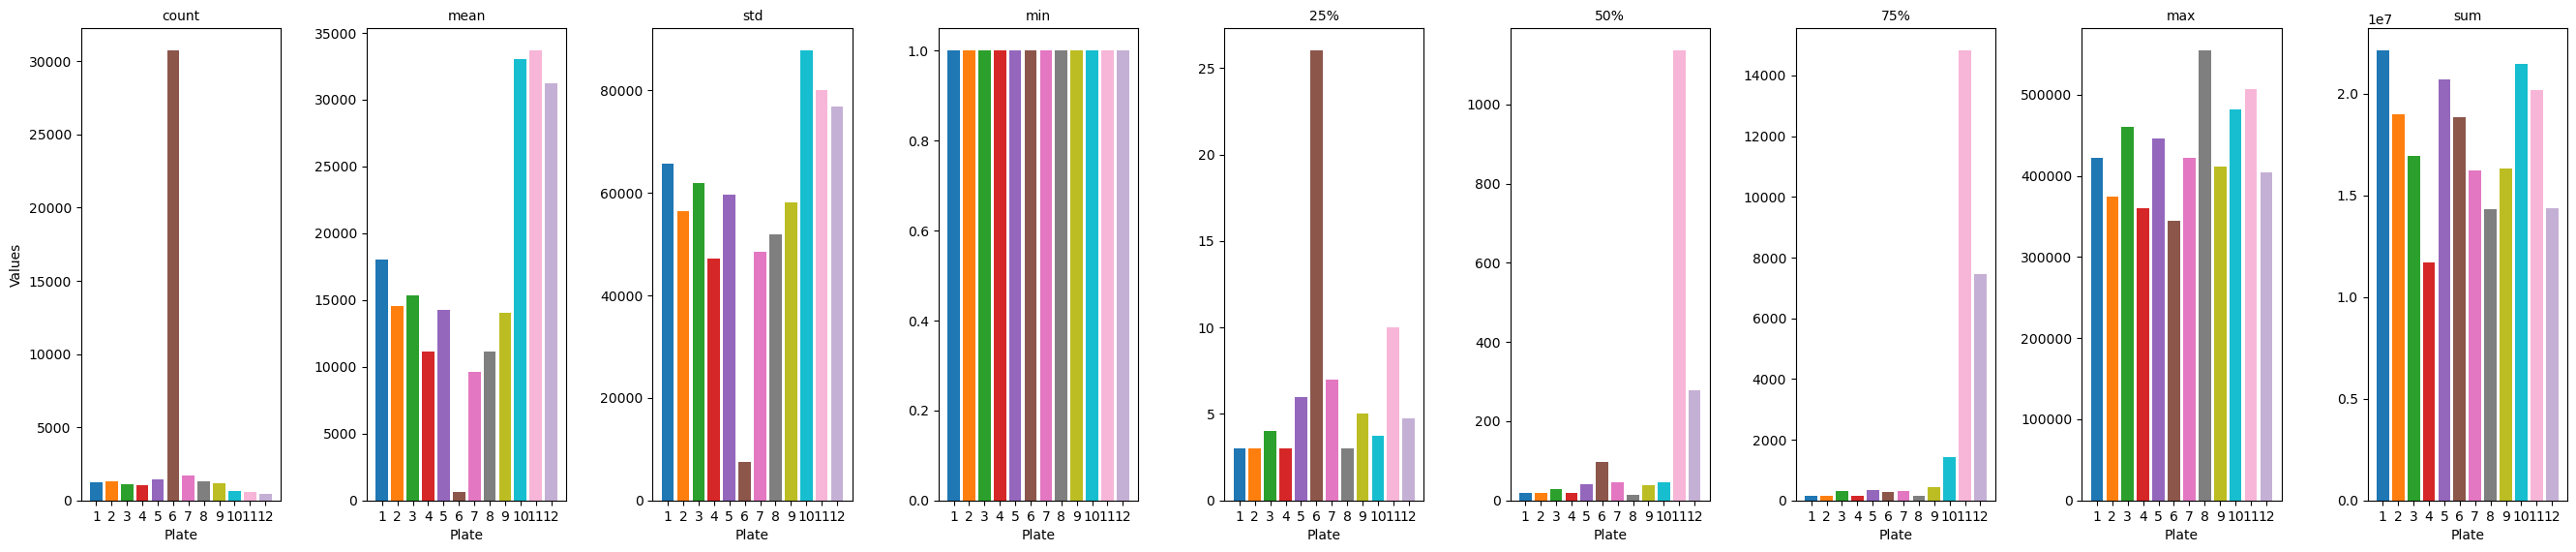

In [10]:
import matplotlib.pyplot as plt

num_cols = len(info_df.columns)
fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 3, 6), sharey=False)
fig.tight_layout(pad=3.0)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#f7b6d8', '#c5b0d5', 
          '#ff9896']


for i, col in enumerate(info_df.columns):
    ax = axes[i]
    ax.bar(info_df.index, info_df[col], color=colors)
    ax.set_title(col, fontsize=10)
    ax.set_xticks(info_df.index)
    ax.set_xlabel("Plate")
    if i == 0:
        ax.set_ylabel("Values")

plt.show()

In [11]:
otu_counts = {}

otu_plate_count = Megabarcoding_df.groupby(['OTU', 'Plate']).size().reset_index(name='count')
otu_plate_distinct_count = otu_plate_count.groupby('OTU')['Plate'].nunique()
otus_on_one_plate = otu_plate_distinct_count[otu_plate_distinct_count == 1].index
unique_otus_per_plate = otu_plate_count[otu_plate_count['OTU'].isin(otus_on_one_plate)]
unique_otus_count_per_plate = unique_otus_per_plate.groupby('Plate')['OTU'].nunique()

otu_counts['Sum of OTUs per sample per plate'] = Megabarcoding_df.groupby('Plate')['OTU'].count()
otu_counts['Number of OTUs per plate'] = Megabarcoding_df.groupby('Plate')['OTU'].nunique()
otu_counts['Number of unique OTUs per plate'] = unique_otus_count_per_plate
otu_counts_df = pd.DataFrame(otu_counts).reset_index()

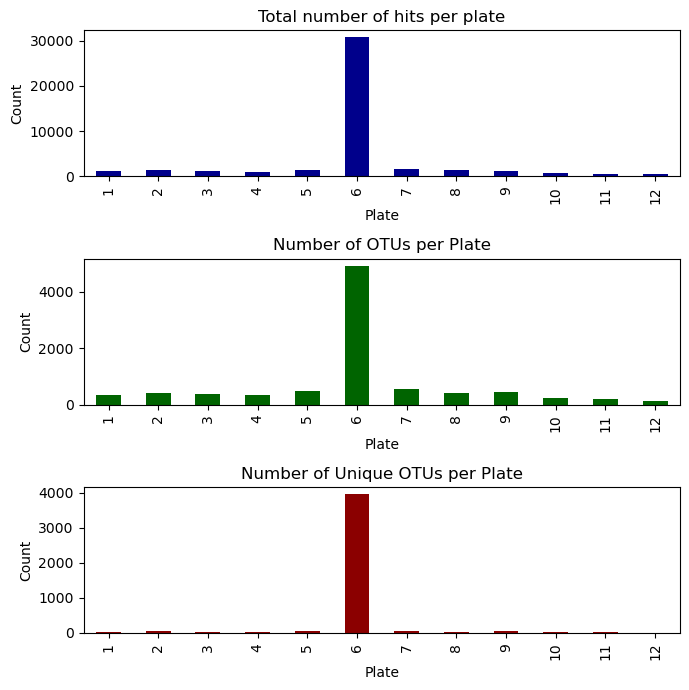

,Plate,Sum of OTUs per sample per plate,Number of OTUs per plate,Number of unique OTUs per plate
0,1,1223,333,26
1,2,1306,398,53
2,3,1104,363,38
3,4,1048,355,25
4,5,1453,469,61
5,6,30718,4924,3970
6,7,1681,546,64
7,8,1283,426,35
8,9,1158,438,44
9,10,648,221,23


In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))

otu_counts_df.plot.bar(x='Plate', y='Sum of OTUs per sample per plate', ax=axes[0], color='darkblue', legend=False)
axes[0].set_title('Total number of hits per plate')
axes[0].set_ylabel('Count')

otu_counts_df.plot.bar(x='Plate', y='Number of OTUs per plate', ax=axes[1], color='darkgreen', legend=False)
axes[1].set_title('Number of OTUs per Plate')
axes[1].set_ylabel('Count')

otu_counts_df.plot.bar(x='Plate', y='Number of unique OTUs per plate', ax=axes[2], color='darkred', legend=False)
axes[2].set_title('Number of Unique OTUs per Plate')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()
otu_counts_df

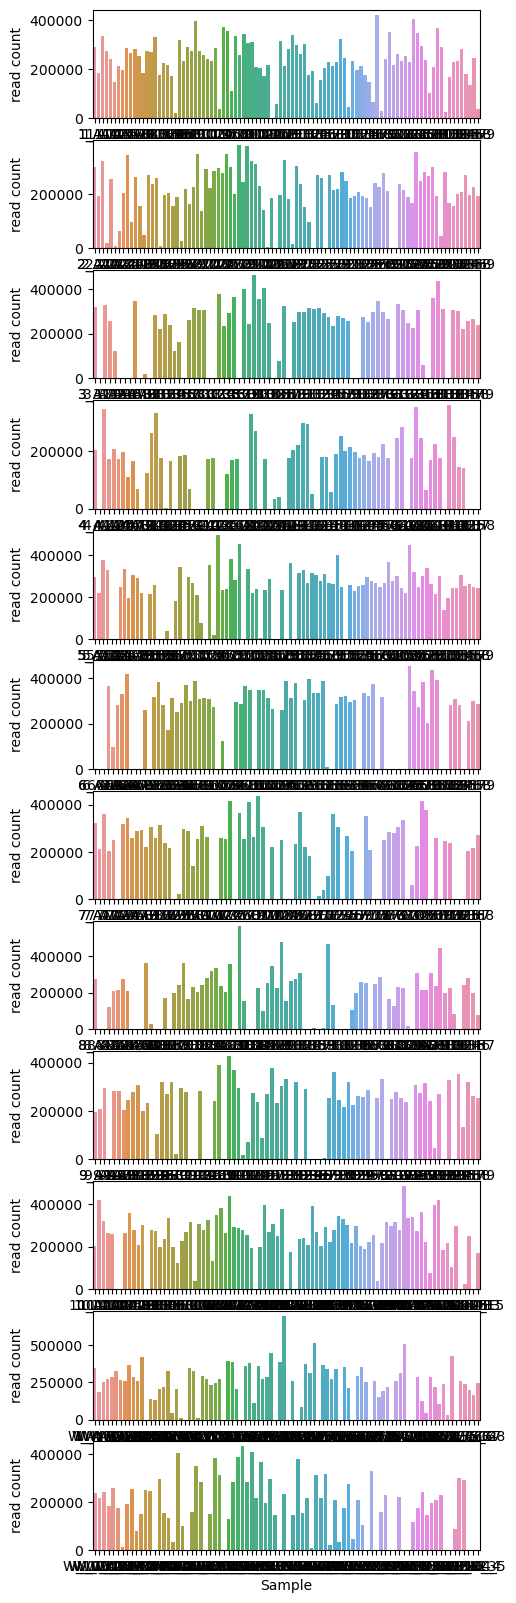

In [13]:
import seaborn as sns

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(5,20))
for plate in range(1,13):
    sns.barplot(data=pd.DataFrame(Megabarcoding_df[Megabarcoding_df['Plate'] == plate].groupby('Sample')['read count'].sum()).reset_index(), x='Sample', y='read count', ax=axes[plate-1])
    

In [14]:
Plate_6 = pd.DataFrame(Megabarcoding_df[Megabarcoding_df['Plate'] == 6].groupby('Sample')['read count'].sum()).reset_index()

<Axes: xlabel='Sample', ylabel='read count'>

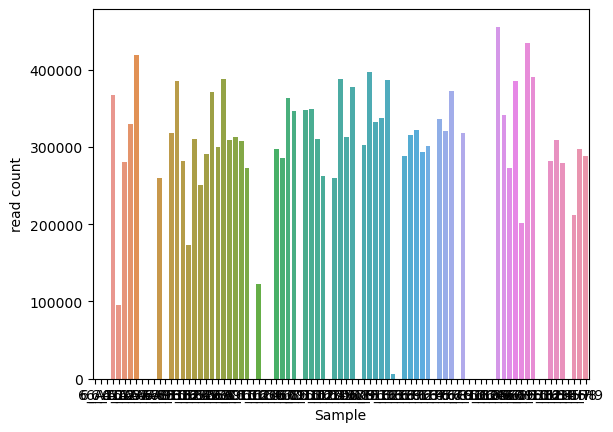

In [15]:
import seaborn as sns

sns.barplot(data=Plate_6, x='Sample', y='read count')

In [16]:
print(f'Total reads: {Megabarcoding_df['read count'].sum()}')
print(f'Total reads without NCs: {Megabarcoding_df_woNC['read count'].sum()}')
print('Information about average reads per sample:')
pd.DataFrame(Megabarcoding_df_woNC.groupby('Sample')['read count'].sum().describe().round(2))

Total reads: 211969611
Total reads without NCs: 210996383
Information about average reads per sample:


,read count
count,1022.00
mean,206454.39
std,127342.28
min,1.00
25%,122185.75
50%,235094.00
75%,295264.00
max,692588.00


In [17]:
print(f'Total reads without plate 6: {Megabarcoding_df_wo6['read count'].sum()}')
print(f'Total reads without NCs without plate 6: {Megabarcoding_df_woNC_wo6['read count'].sum()}')
print('Information about average reads per sample without plate 6:')
pd.DataFrame(Megabarcoding_df_woNC_wo6.groupby('Sample')['read count'].sum().describe().round(2))

Total reads without plate 6: 193141506
Total reads without NCs without plate 6: 192556530
Information about average reads per sample without plate 6:


,read count
count,938.00
mean,205284.15
std,124729.49
min,1.00
25%,128336.25
50%,232114.50
75%,290874.25
max,692588.00


In [18]:
print('Information about average reads per top hit per sample:')
pd.DataFrame(Megabarcoding_df_woNC.drop_duplicates(subset='Sample')['read count'].describe().round(2))

Information about average reads per top hit per sample:


,read count
count,1022.00
mean,183026.81
std,119256.28
min,1.00
25%,74487.75
50%,207622.50
75%,269166.25
max,554101.00


In [19]:
print('Information about average reads per top hit per sample without plate 6:')
pd.DataFrame(Megabarcoding_df_woNC_wo6.drop_duplicates(subset='Sample')['read count'].describe().round(2))

Information about average reads per top hit per sample without plate 6:


,read count
count,938.00
mean,190260.21
std,118185.50
min,1.00
25%,98364.50
50%,215841.50
75%,273647.50
max,554101.00


In [20]:
print('Information about average number of OTUs per sample:')
pd.DataFrame(Megabarcoding_df_woNC.groupby('Sample').count()['OTU'].describe().round(2))

Information about average number of OTUs per sample:


,OTU
count,1022.00
mean,41.28
std,121.15
min,1.00
25%,3.00
50%,8.00
75%,16.00
max,775.00


In [21]:
print('Information about average number of OTUs per sample without plate 6:')
pd.DataFrame(Megabarcoding_df_woNC_wo6.groupby('Sample').count()['OTU'].describe().round(2))

Information about average number of OTUs per sample without plate 6:


,OTU
count,938.00
mean,12.72
std,19.46
min,1.00
25%,3.00
50%,7.00
75%,14.00
max,205.00


In [22]:
Megabarcoding_df_woNC_wo6_1000 = Megabarcoding_df_woNC_wo6[Megabarcoding_df_woNC_wo6['read count'] > 1000]
print('Information about average number of reads per top hit per sample without plate 6:')
pd.DataFrame(Megabarcoding_df_woNC_wo6_1000.drop_duplicates(subset='Sample')['read count'].describe().round(2))

Information about average number of reads per top hit per sample without plate 6:


,read count
count,792.00
mean,225328.86
std,92923.84
min,1076.00
25%,180074.25
50%,235049.50
75%,281657.50
max,554101.00


In [23]:
pre_filtered_df = Megabarcoding_df[Megabarcoding_df['read count'] > 1000]
EPT = ['Ephemeroptera', 'Plecoptera', 'Trichoptera']
pre_filtered_df = pre_filtered_df[pre_filtered_df['Order'].isin(EPT)]

filtered_df = pre_filtered_df.merge(
    Megabarcoding_max_df,
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])
Megabarcoding_second_df = filtered_df.drop_duplicates(subset='Sample')


In [24]:
Megabarcoding_merged_df = Megabarcoding_max_df.merge(Megabarcoding_second_df[['Sample', 'read count']], on='Sample', how='left')
Megabarcoding_merged_df = Megabarcoding_merged_df.merge(remap[['New_name', 'Plate']], left_on='Sample', right_on= 'New_name', how='left')
Megabarcoding_merged_df.rename(columns={'read count_x': 'read count top hit', 'read count_y': 'read count second highest'}, inplace=True)
Megabarcoding_merged_df['ratio second/top hit'] = Megabarcoding_merged_df['read count second highest'] / Megabarcoding_merged_df['read count top hit']
Megabarcoding_merged_df['ratio top hit/second hit'] = Megabarcoding_merged_df['read count top hit'] / Megabarcoding_merged_df['read count second highest'] 
Megabarcoding_merged_df['distance second/top hit'] =  Megabarcoding_merged_df['read count top hit'] - Megabarcoding_merged_df['read count second highest']

In [25]:
# Same as above, but exclude hits with less than 1000 reads and hits not belonging to EPT
Megabarcoding_merged_df = Megabarcoding_max_df.merge(Megabarcoding_second_df[['Sample', 'read count']], on='Sample', how='left')
Megabarcoding_merged_df = Megabarcoding_merged_df.merge(remap[['New_name', 'Plate']], left_on='Sample', right_on= 'New_name', how='left')
Megabarcoding_merged_df.rename(columns={'read count_x': 'read count top hit', 'read count_y': 'read count second highest'}, inplace=True)
Megabarcoding_merged_df['ratio second/top hit'] = Megabarcoding_merged_df['read count second highest'] / Megabarcoding_merged_df['read count top hit']
Megabarcoding_merged_df['ratio top hit/second hit'] = Megabarcoding_merged_df['read count top hit'] / Megabarcoding_merged_df['read count second highest'] 
Megabarcoding_merged_df['distance second/top hit'] =  Megabarcoding_merged_df['read count top hit'] - Megabarcoding_merged_df['read count second highest']


In [26]:
Megabarcoding_merged_df

,Sample,OTU,Order,Family,Genus,Species,Label,read count top hit,read count second highest,New_name,Plate,ratio second/top hit,ratio top hit/second hit,distance second/top hit
0,10_C2,>OTU_2,Trichoptera,Goeridae,Goera,Goera pilosa,Goera pilosa,295959,NaN,10_C2,10,NaN,NaN,NaN
1,W_3_A5,>OTU_3,Trichoptera,Limnephilidae,Potamophylax,Potamophylax rotundipennis,Potamophylax rotundipennis,239552,9622.0,W_3_A5,10,0.040167,24.896279,229930.0
2,10_B1,>OTU_18,Trichoptera,Beraeidae,Beraeodes,Beraeodes minutus,Beraeodes minutus,203238,NaN,10_B1,10,NaN,NaN,NaN
3,10_C1,>OTU_33,Trichoptera,Sericostomatidae,Notidobia,Notidobia ciliaris,Notidobia ciliaris,227600,NaN,10_C1,10,NaN,NaN,NaN
4,W_3_A4,>OTU_3,Trichoptera,Limnephilidae,Potamophylax,Potamophylax rotundipennis,Potamophylax rotundipennis,259408,9096.0,W_3_A4,10,0.035064,28.518909,250312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,W_8_B7,>OTU_12,Plecoptera,Nemouridae,Nemoura,Nemoura cinerea,Nemoura cinerea,351738,NaN,W_8_B7,12,NaN,NaN,NaN
1032,W_9_A8,>OTU_6,Trichoptera,Limnephilidae,Chaetopteryx,Chaetopteryx villosa,Chaetopteryx villosa,317598,NaN,W_9_A8,12,NaN,NaN,NaN
1033,W_9_C7,>OTU_10,Trichoptera,Limnephilidae,Anabolia,Anabolia nervosa,Anabolia nervosa,331012,NaN,W_9_C7,12,NaN,NaN,NaN
1034,W_9_E11,>OTU_3,Trichoptera,Limnephilidae,Potamophylax,Potamophylax rotundipennis,Potamophylax rotundipennis,17,NaN,W_9_E11,12,NaN,NaN,NaN


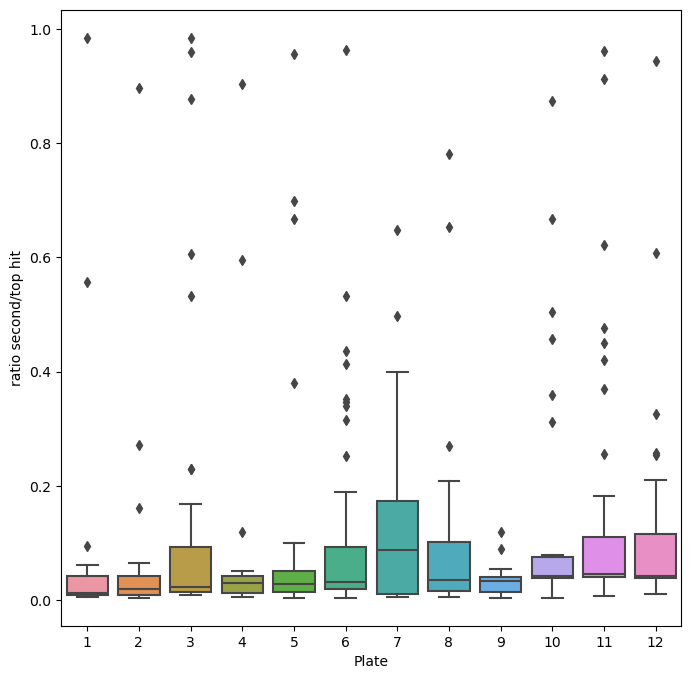

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(Megabarcoding_merged_df, x='Plate', y='ratio second/top hit')

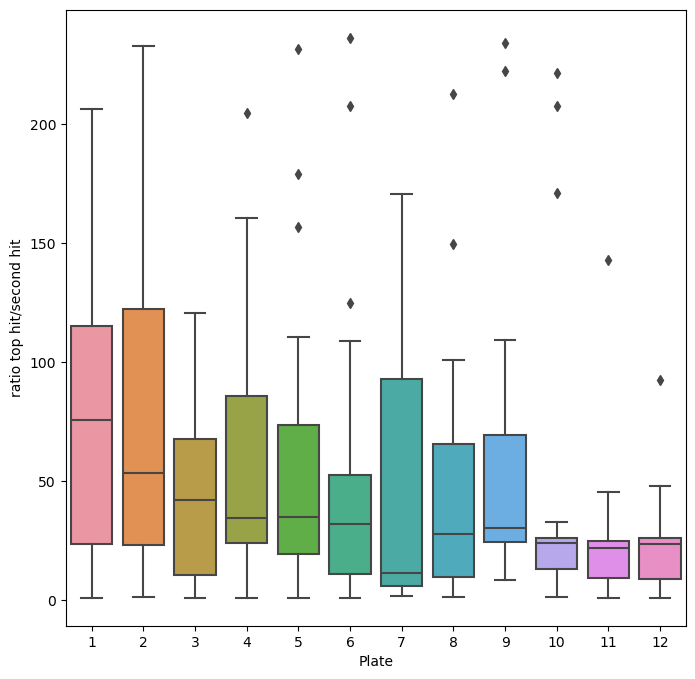

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(Megabarcoding_merged_df, x='Plate', y='ratio top hit/second hit')

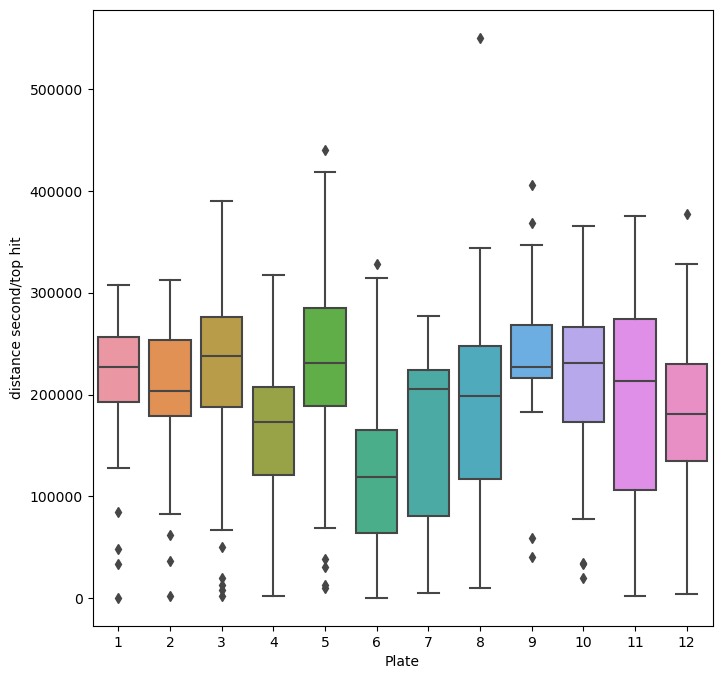

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(Megabarcoding_merged_df, x='Plate', y='distance second/top hit')

In [30]:
EPT = ['Ephemeroptera', 'Plecoptera', 'Trichoptera']
Megabarcoding_df_6 = Megabarcoding_df[Megabarcoding_df['Plate'] == 6]
Megabarcoding_df_6_EPT = Megabarcoding_df_6[Megabarcoding_df_6['Order'].isin(EPT)]
Megabarcoding_df_6_EPT = Megabarcoding_df_6_EPT[Megabarcoding_df_6_EPT['read count'] > 1000]

In [32]:
Megabarcoding_df_6_EPT

,Sample,OTU,Order,Family,Genus,Species,Label,read count,Plate
6463,6_B2,>OTU_1,Trichoptera,Limnephilidae,Limnephilus,Limnephilus lunatus,Limnephilus lunatus,141974,6
6472,6_B2,>OTU_192,Trichoptera,Limnephilidae,Halesus,Halesus radiatus,Halesus radiatus,2116,6
6473,6_B2,>OTU_8,Trichoptera,Limnephilidae,Halesus,Halesus radiatus,Halesus radiatus,1948,6
6476,6_B2,>OTU_49,Trichoptera,Limnephilidae,Limnephilus,NaN,Limnephilus,1802,6
6479,6_B2,>OTU_41,Ephemeroptera,Heptageniidae,Kageronia,Kageronia fuscogrisea,Kageronia fuscogrisea,1609,6
...,...,...,...,...,...,...,...,...,...
36488,6_C12,>OTU_5,Ephemeroptera,Baetidae,Baetis,Baetis rhodani,Baetis rhodani,265581,6
36790,6_D12,>OTU_1,Trichoptera,Limnephilidae,Limnephilus,Limnephilus lunatus,Limnephilus lunatus,303858,6
36791,6_D12,>OTU_24,Trichoptera,Limnephilidae,Limnephilus,NaN,Limnephilus,3406,6
36793,6_D12,>OTU_767,Trichoptera,Limnephilidae,Limnephilus,Limnephilus graecus,Limnephilus graecus,1750,6
